# Finding Heavy Traffic Indicators on I-94

## 1. Introduction

In this project, we are going to analyse a dataset about the westbound traffic on the [I-94](https://en.wikipedia.org/wiki/Interstate_94), an Interstate Highway connecting the Great Lakes and northern Great Plains regions of the United States, in the state of Minnesota. Being westbound, the dataset only focuses on the traffic of vehicles moving from east to west. The traffic data has been collected from a station located between Minneapolis and Saint Paul.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://s3.amazonaws.com/dq-content/524/i94_figma.png")

The goal of our analysis is to determine what are the factors that influence heavy traffic on I-94.

### 1.1 Getting the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# for data visualization

rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : False}
plt.rcParams.update(rc)

In [3]:
traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

# Showing first and last five rows

display(traffic.head())
display(traffic.tail())

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


There are no null values: this allows us to jump right into a preliminary analysis of the dataset.

## 2. Preliminary Analysis

### 2.1 Traffic Volume

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64




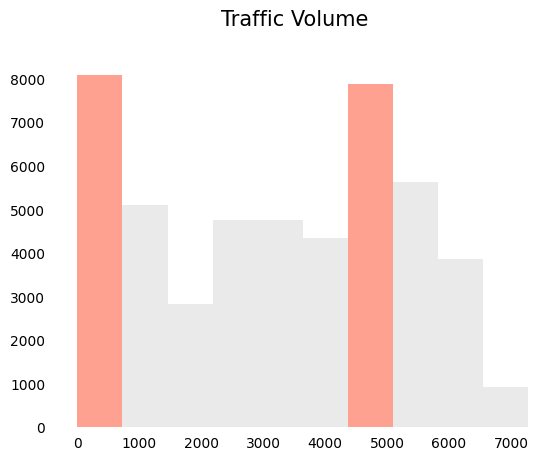

In [5]:
_, _, bars = plt.hist(traffic["traffic_volume"], color="gainsboro", alpha=0.6)
for bar in bars:
    if bar.get_height() > 7000:
        bar.set_facecolor("tomato")
plt.suptitle('Traffic Volume', fontsize=15)
print(traffic["traffic_volume"].describe())
print('\n')

The traffic volume of the dataset is characterized by a **bimodal** distribution.

There is a first peak, where most of the values fall between 0 and around 700 (⅒ of the total, since the bins of the histogram are 10), and a second peak where the number of the amount of vehicles falls between around 4,300 and 5,000.

These two modes that appear from a first exploration of the dataset might be influenced by a number of factors - such as the time of the day.

To divide the dataset into two parts, daytime and nighttime, we could use the following parameters:

* Daytime: hours from 7 a.m. to 7 p.m. (12 hours)
* Nighttime: hours from 7 p.m. to 7 a.m. (12 hours)

#### 2.1.1 Traffic Volume by Time of the Day

In [6]:
traffic["date_time"] = pd.to_datetime(traffic["date_time"])

In [7]:
daytime = traffic[(traffic["date_time"].dt.hour >= 7).copy()
      & (traffic["date_time"].dt.hour < 19)].copy()
nighttime = traffic[(traffic["date_time"].dt.hour >= 19).copy()
      | (traffic["date_time"].dt.hour < 7)].copy()

Let's compare the traffic volume at night and during day to see if there are significant differences.

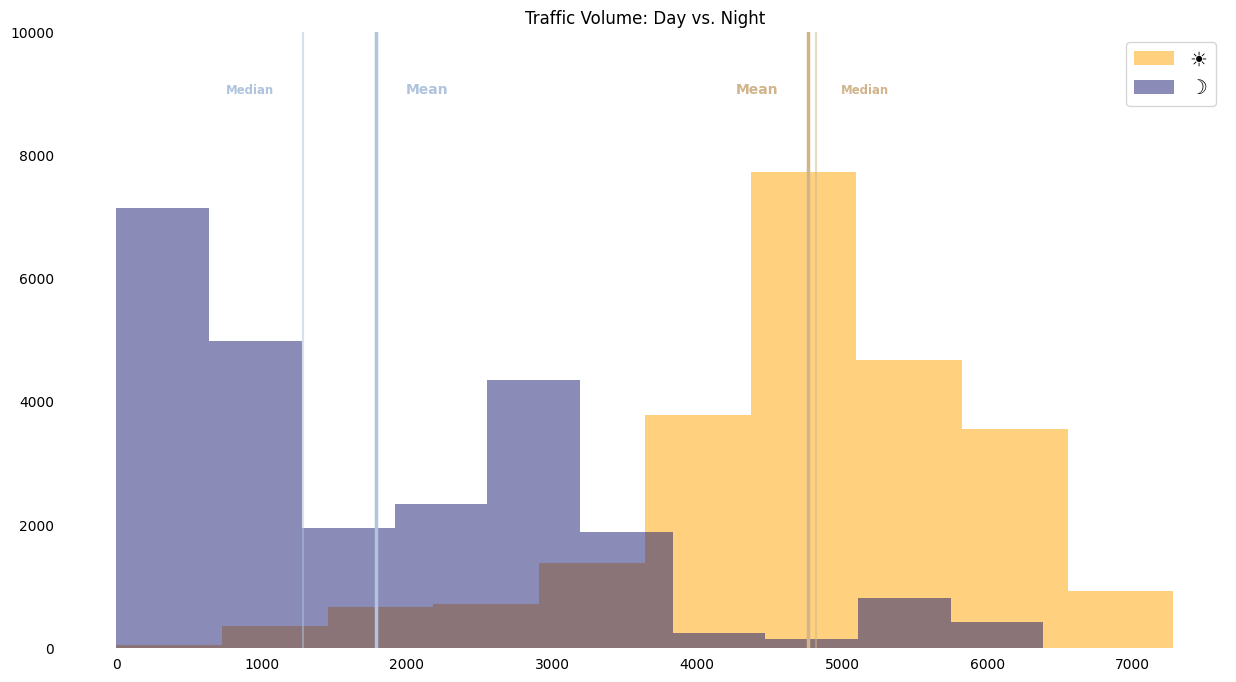

In [8]:
plt.figure(figsize=(15, 8))

plt.hist(daytime["traffic_volume"], color='orange', alpha=0.5, label='☀️')

plt.axvline(daytime["traffic_volume"].mean(), color='tan', linewidth=2.5)
plt.axvline(daytime["traffic_volume"].median(), color='tan', alpha=0.5)

plt.text(daytime["traffic_volume"].mean()-200, 9000, 'Mean', ha='right', rotation='horizontal', color='tan', weight='bold')
plt.text(daytime["traffic_volume"].median()+500, 9000, 'Median', ha='right', rotation='horizontal', size='small', color='tan', weight='semibold')

plt.hist(nighttime["traffic_volume"], color='midnightblue', alpha=0.5, label='☽')

plt.axvline(nighttime['traffic_volume'].mean(), color='lightsteelblue', linewidth=2.5)
plt.axvline(nighttime['traffic_volume'].median(), color='lightsteelblue', alpha=0.5)

plt.text(nighttime["traffic_volume"].mean()+500, 9000, 'Mean', ha='right', rotation='horizontal', color='lightsteelblue', weight='bold')
plt.text(nighttime["traffic_volume"].median()-200, 9000, 'Median', ha='right', rotation='horizontal', size='small', color='lightsteelblue',
         weight='semibold')

plt.ylabel("")
plt.title("Traffic Volume: Day vs. Night")
plt.legend(fontsize="x-large")

plt.ylim(0, 10000)

plt.show()

In [9]:
print("Traffic Volume: Day")
print(daytime["traffic_volume"].describe()[['max', 'mean', '50%']])
print("\n------------------------\n")
print("Traffic Volume: Night")
print(nighttime["traffic_volume"].describe()[['max', 'mean', '50%']])

Traffic Volume: Day
max     7280.000000
mean    4762.047452
50%     4820.000000
Name: traffic_volume, dtype: float64

------------------------

Traffic Volume: Night
max     6386.000000
mean    1785.377441
50%     1287.000000
Name: traffic_volume, dtype: float64


Based on the histograms and the summary statistics for the column `traffic_volume`, traffic on I-94 is lighter at night compared to during the day. 

It is immediately clear from the comparison of the two histograms that the distribution of the vehicles circulating at night is heavily right-skewed, with a median of 1287 and a mean of 1785.38 which is heavily pulled to the right, while that of vehicles passing during the day is only slightly left-skewed - the median and the mean are roughly the same.

As for the most frequent values, we can see from the histograms that

* at night, most values fall between 0 and around 600,
* during the day, they concentrate between around 4,300 and 5,000.

This ties with the previous finding of two modes.

Based on this, it is advisable to only focus on the daytime.

## 3. Analysis

From a preliminary comparison between the daytime and nighttime data, we found that traffic is generally heavier during the day. Based on the column we have at our disposal, some of the indicators that we may wish to look at are **time** and **weather**.

Let's start with time.

### 3.1 Time

We can expect there may be an influence on traffic depending on the time of the year - such as the month, the day of the week, the hour or whether it is a national holiday.

Let's explore each separetely.

#### 3.1.1 Traffic Volume by Month

In [11]:
daytime['month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()
by_month['traffic_volume']

TypeError: Could not convert ClearCloudsCloudsClearCloudsCloudsCloudsCloudsClearCloudsCloudsClearClearCloudsHazeHazeSnowCloudsCloudsSnowSnowMistSnowHazeSnowHazeSnowCloudsSnowMistFogSnowMistSnowMistSnowMistSnowMistHazeSnowMistHazeSnowMistSnowMistMistMistHazeSnowSnowSnowMistSnowMistSnowMistSnowClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsMistMistMistMistHazeHazeMistHazeHazeHazeHazeHazeClearCloudsCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistMistMistHazeCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainRainDrizzleDrizzleRainRainDrizzleMistMistMistMistDrizzleMistFogDrizzleMistFogDrizzleMistDrizzleMistDrizzleMistFogDrizzleMistMistDrizzleDrizzleMistDrizzleRainSnowSnowHazeSnowCloudsCloudsSnowCloudsCloudsCloudsCloudsSnowSnowHazeSnowHazeHazeSnowSnowHazeSnowSnowHazeSnowHazeCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsClearCloudsCloudsClearClearClearClearClearCloudsCloudsClearClearMistSnowCloudsCloudsCloudsCloudsSnowSnowSnowMistSnowCloudsCloudsClearCloudsCloudsSnowSnowSnowHazeCloudsCloudsClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistMistCloudsCloudsCloudsCloudsHazeSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowHazeCloudsCloudsHazeHazeHazeCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowMistSnowHazeMistSnowSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowSnowSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainMistSnowSnowSnowMistMistMistMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsSnowSnowSnowHazeHazeSnowHazeSnowMistRainHazeMistHazeSnowMistMistHazeCloudsSnowCloudsSnowCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearCloudsCloudsHazeSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsClearClearClearCloudsCloudsCloudsCloudsCloudsClearCloudsClearClearCloudsClearClearClearClearCloudsCloudsClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistMistMistMistMistMistMistMistMistMistMistCloudsMistMistMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainRainRainCloudsCloudsCloudsCloudsCloudsSnowCloudsCloudsRainCloudsCloudsCloudsSnowFogSnowMistHazeSnowMistHazeSnowMistHazeSnowCloudsCloudsClearCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsHazeSnowMistRainSnowMistHazeMistSnowRainHazeRainHazeRainSnowRainHazeHazeHazeCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainRainRainRainCloudsSnowSnowRainSnowSnowHazeSnowCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearCloudsCloudsCloudsSnowHazeSnowSnowSnowHazeSnowHazeHazeSnowHazeHazeHazeCloudsClearClearCloudsCloudsCloudsClearClearClearClearClearClearClearClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainCloudsSnowRainRainSnowMistCloudsCloudsCloudsSnowSnowHazeCloudsCloudsCloudsCloudsCloudsCloudsSnowMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainCloudsCloudsCloudsRainRainRainRainRainRainRainRainClearClearClearClearClearClearClearClearClearClearRainRainClearClearClearClearClearCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsClearMistFogFogMistFogMistSnowMistSnowClearClearClearCloudsCloudsClearClearCloudsClearCloudsClearClearClearClearClearClearCloudsRainCloudsHazeSnowMistSnowMistRainSnowMistSnowSnowMistMistSnowSnowMistSnowMistMistSnowMistSnowMistSnowMistSnowSnowMistSnowMistSnowMistCloudsCloudsSnowHazeMistSnowHazeCloudsCloudsClearClearClearClearClearClearClearClearHazeSnowHazeMistSnowSnowSnowHazeMistSnowClearClearClearClearClearClearCloudsSnowHazeCloudsCloudsHazeHazeHazeMistHazeMistHazeMistMistHazeHazeMistMistHazeMistSnowSnowCloudsCloudsClearClearCloudsCloudsCloudsSnowHazeSnowHazeHazeClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearCloudsCloudsCloudsSnowMistSnowMistHazeSnowMistHazeMistSnowMistHazeMistHazeHazeMistMistHazeMistHazeSnowHazeMistSnowHazeMistSnowHazeMistSnowHazeMistSnowHazeSnowMistSnowHazeSnowSnowHazeSnowCloudsCloudsCloudsSnowHazeSnowCloudsCloudsHazeHazeMistSnowMistSnowSnowMistSnowMistMistSnowHazeHazeMistMistFogSnowMistFogMistFogMistHazeMistRainMistRainSnowSnowMistHazeSnowSnowSnowHazeCloudsSnowCloudsSnowMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsClearClearCloudsRainDrizzleCloudsMistFogMistFogClearCloudsClearCloudsClearCloudsClearCloudsClearClearCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsSnowSnowSnowSnowMistSnowHazeMistHazeSnowMistRainMistHazeSnowDrizzleMistSnowMistSnowCloudsCloudsSnowSnowSnowSnowCloudsHazeClearClearClearClearClearHazeSnowHazeHazeClearClearClearClearClearClearClearCloudsMistMistMistMistClearClearCloudsHazeHazeCloudsCloudsCloudsHazeClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsClearCloudsClearClearHazeClearClearClearClearClearClearClearClearSnowSnowClearClearCloudsClearCloudsSnowSnowSnowSnowCloudsCloudsCloudsSnowSnowSnowSnowMistHazeSnowMistSnowMistFogSnowMistSnowMistHazeHazeSnowMistSnowSnowMistSnowMistFogSnowMistSnowFogMistSnowMistSnowMistSnowFogHazeHazeSnowMistHazeHazeClearSnowMistSnowMistSnowMistSnowMistSnowHazeSnowSnowCloudsClearClearClearClearHazeCloudsHazeClearClearSnowSnowHazeSnowSnowHazeHazeClearCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsSnowSnowCloudsCloudsClearClearSnowClearClearClearClearClearClearClearClearClearMistMistSnowClearClearClearClearCloudsClearClearCloudsClearCloudsMistHazeMistMistHazeMistHazeHazeMistHazeMistHazeMistHazeMistHazeHazeHazeCloudsMistDrizzleMistMistHazeFogHazeMistFogHazeMistMistHazeMistHazeMistHazeMistMistMistMistMistHazeHazeMistMistHazeMistHazeClearClearClearClearClearClearClearClearMistFogMistHazeMistHazeFogMistHazeHazeMistMistMistMistHazeMistMistCloudsCloudsMistDrizzleFogRainDrizzleMistSnowDrizzleMistRainSnowDrizzleMistMistMistMistMistFogMistFogMistMistFogMistFogMistRainFogDrizzleMistDrizzleRainDrizzleMistRainDrizzleMistFogRainDrizzleMistMistRainDrizzleMistRainMistFogMistFogRainMistFogDrizzleMistFogDrizzleMistFogMistFogMistFogMistFogMistFogMistMistMistMistCloudsCloudsMistMistDrizzleMistSnowDrizzleMistSnowMistSnowMistSnowRainMistRainMistMistSnowRainMistSnowMistMistHazeMistMistMistCloudsCloudsCloudsClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowMistSnowMistSnowMistHazeSnowMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsClearClearClearClearCloudsHazeCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowSnowCloudsCloudsClearClearCloudsClearCloudsCloudsCloudsSnowSnowMistSnowMistMistSnowMistHazeMistMistHazeMistMistMistMistMistCloudsCloudsCloudsSnowSnowCloudsCloudsSnowSnowSnowRainSnowRainSnowClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsClearSnowMistSnowMistSnowHazeCloudsClearClearClearCloudsCloudsCloudsCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearHazeClearClearCloudsCloudsClearCloudsClearCloudsCloudsClearHazeMistMistCloudsCloudsClearCloudsCloudsCloudsClearCloudsCloudsCloudsClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearCloudsClearCloudsClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistHazeMistHazeMistHazeMistHazeMistMistMistHazeMistHazeMistMistHazeMistHazeDrizzleMistSnowMistSnowMistSnowMistSnowMistSnowMistSnowMistSnowMistSnowMistSnowMistSnowSnowHazeSnowClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsSnowSnowMistSnowMistSnowHazeSnowHazeSnowMistSnowFogSnowMistFogSnowMistFogSnowMistSnowMistHazeSnowMistSnowHazeHazeSnowHazeSnowSnowHazeSnowHazeHazeSnowHazeSnowHazeSnowSnowSnowSnowSnowMistSnowSnowMistClearClearClearClearClearClearClearClearCloudsCloudsCloudsClearClearCloudsClearClearClearClearClearClearCloudsCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistCloudsCloudsMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearMistMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowSnowSnowSnowMistSnowMistFogSnowMistFogSnowFogMistSnowFogSnowFogSnowFogSnowFogSnowFogMistCloudsCloudsCloudsCloudsCloudsClearCloudsClearCloudsClearHazeCloudsCloudsSnowMistMistMistMistMistMistHazeCloudsMistMistMistFogMistFogMistFogMistFogSnowMistSnowMistMistMistSnowMistMistMistHazeMistHazeSnowCloudsCloudsClearClearCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsClearClearClearClearCloudsClearCloudsCloudsCloudsClearClearClearSnowSnowSnowSnowSnowSnowHazeSnowSnowSnowSnowSnowSnowClearClearCloudsClearClearClearClearClearClearClearClearClearSnowSnowCloudsCloudsCloudsCloudsCloudsClearCloudsClearClearClearClearClearClearClearSnowClearClearClearClearCloudsCloudsClouds to numeric

NameError: name 'by_month' is not defined

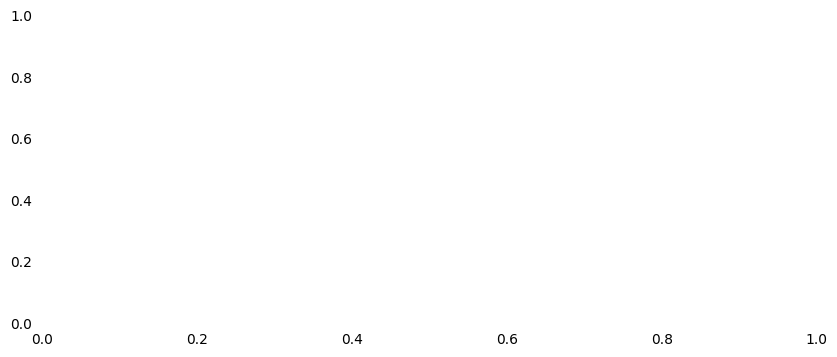

In [12]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
          'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(months, by_month["traffic_volume"], color='gainsboro', alpha=0.5, linewidth=2) # main lineplot

plt.plot(months[:3], by_month['traffic_volume'][:3], color='lightsteelblue', alpha=0.5, linewidth=2.5, marker='o', markevery=2)

for x,y in zip(months[:3:2],by_month['traffic_volume'][:3:2]):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.plot(months[9:], by_month['traffic_volume'][9:], color='lightsteelblue', alpha=0.5, linewidth=2.5, marker='o', markevery=2)

for x,y in zip(months[9::2],by_month['traffic_volume'][9::2]):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.plot(months[5:8], by_month['traffic_volume'][5:8], color='lightsteelblue', alpha=0.5, linewidth=2.5, marker='o')

for x,y in zip(months[5:8],by_month['traffic_volume'][5:8]):

    label = "{:.2f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
ax.add_patch(Rectangle((0, 0),
                       2,
                       5000,
                       color='mediumpurple',
                       alpha=0.2))

ax.add_patch(Rectangle((10, 0),
                       1,
                       5000,
                       color='mediumpurple',
                       alpha=0.2))

ax.add_patch(Rectangle((4, 0),
                       4,
                       5000,
                       color='coral',
                       alpha=0.2))

plt.ylim(4300, 5000)
plt.xticks(ticks=months)
plt.yticks([])
plt.suptitle("Traffic Volume: Monthly Averages", fontsize=15)
plt.show()

Looking at how traffic volume changes each month on average, we can observe that the months with the lowest monthly averages are January, July and December.

It is worth noticing that during the colder months - as we can extrapolate from [WeatherSpark](https://weatherspark.com/y/146218/Average-Weather-at-Minneapolis-St-Paul-International-Wold-Chamberlain-Airport-Minnesota-United-States-Year-Round) - traffic is generally lighter (Jan-Feb, Nov-Dec), whereas for the hottest period of the year there is a downward spike in July.

This might be an effect of the weather conditions that characterize these two seasons, or might be a result of other factors.

Let's now turn to the day of the week to see other peculiarities.

#### 3.1.2 Traffic Volume by Day of the Week

In [13]:
daytime['dayofweek'] = daytime['date_time'].dt.dayofweek
by_dayofweek = daytime.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

TypeError: Could not convert CloudsCloudsCloudsCloudsCloudsClearCloudsCloudsClearClearCloudsCloudsMistMistMistMistCloudsClearCloudsClearClearCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearCloudsSnowMistSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowCloudsCloudsCloudsFogFogMistFogMistMistFogMistFogFogMistMistFogMistMistMistMistMistSnowMistSnowFogSnowMistSnowFogSnowMistFogSnowSnowMistSnowFogSnowFogSnowSnowFogSnowSnowSnowFogSnowSnowFogSnowSnowFogSnowSnowMistSnowFogSnowMistMistMistMistMistMistMistMistMistMistMistCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistHazeMistMistCloudsHazeCloudsCloudsCloudsClearClearCloudsCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowSnowHazeSnowHazeHazeSnowSnowHazeSnowSnowHazeSnowHazeCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowHazeCloudsCloudsCloudsRainMistSnowSnowSnowMistClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistHazeSnowMistHazeSnowMistSnowRainFogSnowMistSnowSnowFogSnowMistSnowFogSnowMistSnowMistSnowMistSnowDrizzleMistRainSnowMistSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistHazeMistHazeMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistSnowCloudsCloudsCloudsCloudsCloudsClearClearCloudsCloudsCloudsCloudsSnowMistMistSnowSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistMistHazeCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearSnowSnowSnowSnowSnowSnowRainMistSnowMistRainSnowRainMistSnowRainMistSnowRainMistRainMistSnowSnowRainRainCloudsCloudsCloudsCloudsCloudsRainRainRainRainMistRainClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsClearClearCloudsClearClearClearClearClearClearClearClearClearClearClearClearThunderstormMistThunderstormThunderstormRainMistThunderstormThunderstormHazeMistRainHazeMistRainMistCloudsCloudsCloudsThunderstormThunderstormThunderstormRainMistRainRainMistThunderstormRainThunderstormCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsClearCloudsClearCloudsCloudsRainMistDrizzleRainMistRainMistRainMistDrizzleRainRainRainMistRainMistDrizzleRainMistRainMistRainRainMistMistClearClearClearClearClearClearClearClearClearClearRainThunderstormMistRainCloudsCloudsRainClearClearClearCloudsCloudsRainCloudsCloudsClearClearClearClearClearClearCloudsClearClearClearCloudsRainRainRainRainRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearRainThunderstormRainThunderstormFogDrizzleRainMistThunderstormClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsClearClearCloudsCloudsCloudsCloudsRainRainCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearRainRainClearClearCloudsClearClearCloudsClearRainThunderstormRainMistThunderstormRainMistMistHazeMistHazeRainHazeMistHazeClearClearClearClearClearClearClearClearClearClearCloudsCloudsClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsClearClearCloudsCloudsRainCloudsCloudsDrizzleCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistSnowSnowSnowMistHazeMistHazeHazeRainHazeRainSnowMistRainSnowFogMistRainSnowMistFogRainSnowMistDrizzleHazeSnowSnowSnowCloudsCloudsCloudsCloudsCloudsCloudsSnowSnowRainSnowMistFogHazeRainSnowRainSnowCloudsCloudsCloudsCloudsSnowSnowSnowHazeSnowCloudsSnowSnowHazeSnowCloudsCloudsCloudsCloudsSnowHazeSnowHazeSnowSnowSnowSnowRainSnowRainSnowSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowCloudsCloudsRainCloudsCloudsCloudsSnowSnowRainSnowSnowHazeSnowCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainRainRainRainRainCloudsCloudsCloudsRainRainRainRainRainRainRainCloudsRainCloudsCloudsCloudsRainRainRainCloudsCloudsRainRainCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainCloudsRainRainCloudsRainRainCloudsCloudsCloudsCloudsClearClearClearRainRainRainRainRainRainRainRainRainRainRainRainCloudsCloudsClearCloudsClearCloudsClearClearClearClearClearHazeRainMistRainMistMistRainMistRainMistDrizzleRainMistDrizzleRainMistMistCloudsMistRainMistRainMistDrizzleCloudsRainDrizzleRainRainDrizzleThunderstormRainThunderstormMistRainMistThunderstormRainThunderstormMistRainThunderstormMistRainThunderstormMistRainMistThunderstormRainRainMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainMistRainMistRainRainClearRainClearCloudsRainRainRainRainRainDrizzleRainDrizzleRainCloudsRainCloudsCloudsCloudsCloudsCloudsClearMistFogClearClearClearClearClearClearCloudsCloudsThunderstormThunderstormCloudsRainThunderstormRainThunderstormMistRainCloudsCloudsCloudsCloudsCloudsRainRainRainRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistMistRainMistRainHazeHazeCloudsClearClearClearClearCloudsRainFogMistRainMistFogRainClearClearClearCloudsClearClearRainThunderstormHazeRainMistDrizzleRainMistDrizzleRainMistDrizzleRainMistRainMistDrizzleRainMistDrizzleRainMistSmokeHazeDrizzleRainMistSmokeHazeDrizzleRainSmokeHazeMistRainSmokeHazeMistSmokeHazeSmokeHazeClearRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearCloudsCloudsClearClearClearClearClearCloudsCloudsClearCloudsClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearCloudsCloudsCloudsClearClearClearClearClearCloudsCloudsCloudsCloudsClearCloudsClearClearCloudsClearClearClearClearClearCloudsRainRainRainRainCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainMistMistMistCloudsCloudsClearClearClearClearClearClearClearClearClearClearCloudsClearClearClearHazeHazeClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsClearCloudsCloudsRainThunderstormRainRainThunderstormRainThunderstormCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsRainHazeHazeRainRainDrizzleRainDrizzleRainDrizzleRainRainHazeDrizzleRainClearClearClearRainCloudsCloudsThunderstormHazeMistCloudsClearClearClearHazeClearClearClearClearClearClearClearThunderstormRainRainDrizzleRainDrizzleRainMistDrizzleMistCloudsClearClearCloudsClearCloudsSnowMistSnowMistMistHazeMistSnowMistRainSnowMistFogMistMistCloudsClearCloudsCloudsRainMistSnowRainMistSnowRainMistDrizzleSnowSnowCloudsRainDrizzleSnowDrizzleMistMistMistCloudsCloudsCloudsCloudsClearClearCloudsClearClearCloudsSnowSnowMistFogFogMistFogMistSnowMistSnowClearClearClearCloudsHazeSnowHazeMistSnowSnowSnowHazeMistSnowCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearMistFogSnowMistFogMistFogMistHazeMistRainMistRainSnowSnowMistHazeMistFogMistSnowFogMistFogMistFogMistMistHazeMistHazeHazeMistSnowHazeSnowSnowHazeHazeSnowHazeSnowHazeHazeSnowSnowSnowHazeSnowHazeSnowMistMistMistHazeMistHazeMistClearCloudsCloudsHazeMistClearClearCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearCloudsClearFogMistClearCloudsCloudsCloudsCloudsMistFogDrizzleRainMistFogMistFogMistMistHazeHazeMistHazeMistClearClearClearClearCloudsCloudsClearClearCloudsClearCloudsCloudsClearClearClearSnowSnowSnowSnowSnowCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearHazeClearCloudsCloudsCloudsHazeCloudsCloudsRainRainMistThunderstormRainThunderstormMistRainMistThunderstormDrizzleRainDrizzleMistMistDrizzleMistHazeDrizzleMistHazeRainCloudsCloudsCloudsClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsHazeCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainRainThunderstormRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainCloudsCloudsRainRainRainCloudsCloudsCloudsCloudsCloudsThunderstormRainRainFogMistMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearRainCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainRainCloudsThunderstormThunderstormRainThunderstormCloudsThunderstormThunderstormRainThunderstormCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearMistFogThunderstormMistMistRainCloudsClearClearClearClearClearClearCloudsThunderstormCloudsClearCloudsCloudsCloudsCloudsThunderstormCloudsCloudsCloudsDrizzleRainDrizzleRainClearClearClearClearClearClearCloudsCloudsCloudsCloudsThunderstormRainRainThunderstormClearClearClearClearRainClearClearCloudsClearClearClearClearCloudsCloudsClearClearClearClearClearClearCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsRainRainRainRainRainRainRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainRainCloudsRainMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearCloudsClearClearClearClearClearClearClearCloudsCloudsClearClearClearDrizzleRainRainThunderstormRainThunderstormRainThunderstormRainRainMistRainMistDrizzleRainRainThunderstormRainMistRainMistMistRainDrizzleMistFogMistFogMistMistMistCloudsRainDrizzleRainCloudsCloudsCloudsRainMistSnowSnowMistHazeMistHazeSnowMistSnowMistHazeSnowMistHazeSnowHazeSnowCloudsSnowSnowSnowSnowCloudsCloudsCloudsClearClearSnowHazeSnowHazeCloudsClearClearClearCloudsSnowSnowSnowSnowSnowHazeMistSnowSnowSnowSnowSnowSnowCloudsCloudsCloudsSnowSnowSnowSnowMistSnowHazeMistHazeSnowMistRainMistHazeSnowDrizzleMistSnowMistSnowCloudsCloudsCloudsSnowSnowSnowSnowMistHazeSnowMistSnowMistFogSnowMistSnowMistHazeHazeSnowMistHazeMistMistHazeMistHazeHazeMistHazeMistHazeMistHazeMistHazeHazeHazeCloudsDrizzleMistSnowDrizzleMistSnowMistSnowMistSnowRainMistRainMistMistSnowRainMistSnowMistMistHazeMistMistSnowSnowMistSnowMistMistSnowMistHazeMistMistHazeMistMistMistMistMistClearClearClearClearCloudsClearClearCloudsClearCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsRainRainRainRainRainRainRainRainClearCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsDrizzleMistMistDrizzleMistRainMistDrizzleRainDrizzleDrizzleCloudsCloudsCloudsCloudsThunderstormThunderstormSnowClearSnowCloudsClearClearCloudsCloudsCloudsCloudsCloudsRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsClearMistRainDrizzleFogMistMistClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsMistFogHazeMistFogHazeMistFogHazeMistFogHazeMistHazeMistHazeCloudsMistMistDrizzleRainRainMistRainMistDrizzleRainDrizzleClearCloudsCloudsCloudsCloudsCloudsRainDrizzleRainDrizzleDrizzleRainRainDrizzleRainMistDrizzleRainMistDrizzleCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsRainRainDrizzleDrizzleMistSnowRainRainMistDrizzleDrizzleMistRainDrizzleMistRainRainMistDrizzleRainMistDrizzleRainMistDrizzleRainSnowMistDrizzleSnowMistRainDrizzleRainMistSnowRainDrizzleRainDrizzleClearClearClearCloudsClearCloudsCloudsHazeCloudsClearRainDrizzleRainClearClearClearCloudsThunderstormThunderstormThunderstormRainThunderstormRainMistRainMistThunderstormRainDrizzleCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainHazeRainDrizzleRainRainRainRainRainRainClearClearClearCloudsClearClearClearClearClearClearClearClearMistFogMistFogMistMistCloudsCloudsCloudsThunderstormThunderstormRainRainMistRainMistRainMistClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsThunderstormCloudsCloudsCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistClearCloudsCloudsClearClearClearClearClearClearClearClearMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearMistCloudsCloudsClearClearClearCloudsCloudsCloudsCloudsCloudsMistClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistCloudsClearClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistFogFogMistFogMistFogHazeCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistDrizzleMistMistRainMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsThunderstormRainThunderstormDrizzleCloudsCloudsCloudsRainRainDrizzleThunderstormThunderstormRainRainMistThunderstormDrizzleRainDrizzleRainDrizzleCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearHazeHazeHazeHazeCloudsRainRainThunderstormRainMistThunderstormCloudsCloudsCloudsCloudsCloudsClearCloudsClearClearCloudsCloudsClearCloudsRainRainRainRainMistDrizzleRainRainRainMistRainMistRainDrizzleRainMistRainMistRainRainDrizzleRainDrizzleDrizzleMistRainRainMistMistRainRainCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsRainMistCloudsRainMistThunderstormFogRainThunderstormRainMistThunderstormMistRainDrizzleCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsRainRainRainClearMistMistClearCloudsClearClearCloudsClearClearCloudsCloudsCloudsCloudsCloudsCloudsClearClearCloudsCloudsCloudsCloudsCloudsCloudsRainSnowSnowCloudsSnowHazeSnowMistRainDrizzleRainDrizzleHazeSnowCloudsCloudsCloudsDrizzleClearCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsMistMistMistHazeMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsDrizzleRainRainMistDrizzleDrizzleMistRainMistMistRainDrizzleRainMistDrizzleHazeMistRainDrizzleHazeMistDrizzleRainHazeMistFogHazeMistDrizzleDrizzleMistSnowMistDrizzleSnowMistMistSnowMistSnowMistSnowMistSnowCloudsCloudsCloudsCloudsCloudsMistMistMistHazeMistMistCloudsCloudsCloudsClearCloudsCloudsCloudsMistHazeHazeSnowHazeHazeCloudsHazeCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsClearCloudsClearCloudsClearCloudsCloudsCloudsCloudsSnowMistHazeSnowMistSnowHazeHazeSnowHazeSnowSnowHazeSnowHazeHazeSnowHazeSnowHazeSnowSnowSnowSnowSnowSnowMistSnowMistFogSnowMistFogSnowFogMistSnowFogSnowFogSnowFogSnowFogSnowFogMistClearClearCloudsClearClearClearClearClearClearClearClearClearClearClearClearClearCloudsSnowSnowSnowSnowHazeSnowHazeSnowClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsThunderstormCloudsHazeCloudsCloudsSnowCloudsMistSnowDrizzleHazeMistSnowSnowMistSnowMistSnowMistSnowMistHazeMistSnowSnowMistMistSnowMistSnowClearClearClearCloudsClearClearClearCloudsCloudsClearClearClearSnowSnowSnowSnowRainHazeSnowThunderstormMistSnowRainCloudsCloudsSnowMistHazeDrizzleSnowFogMistSnowFogSnowMistFogClearClearClearClearClearClearClearClearClearClearClearClearCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsSnowCloudsCloudsCloudsRainCloudsCloudsRainSnowRainRainDrizzleRainDrizzleSnowRainMistDrizzleCloudsCloudsCloudsCloudsCloudsClearSnowSnowMistFogSnowMistSnowMistSnowMistSnowMistSnowMistSnowMistSnowHazeMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsSnowSnowSnowMistHazeClearSnowSnowCloudsCloudsCloudsCloudsCloudsCloudsMistMistClearClearClearClearClearClearClearClearClearCloudsRainRainRainDrizzleRainDrizzleDrizzleRainDrizzleClearClearClearClearClearCloudsClearClearClearClearClearClearClearClearCloudsCloudsCloudsMistMistCloudsCloudsCloudsClearCloudsCloudsRainDrizzleRainRainRainDrizzleRainDrizzleRainCloudsCloudsRainRainCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearCloudsCloudsCloudsCloudsCloudsThunderstormThunderstormRainClearClearClearClearClearCloudsCloudsCloudsClearClearCloudsCloudsCloudsCloudsCloudsThunderstormThunderstormThunderstormRainRainRainRainRainRainRainMistThunderstormRainDrizzleDrizzleRainMistRainMistDrizzleMistRainRainMistRainMistDrizzleRainMistCloudsCloudsCloudsCloudsRainRainThunderstormRainThunderstormRainRainCloudsCloudsCloudsClearCloudsCloudsCloudsClearClearCloudsClearClearClearCloudsCloudsClearCloudsCloudsCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearClearClearClearCloudsCloudsClearCloudsMistFogMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsFogMistMistClearClearClearCloudsCloudsCloudsCloudsCloudsThunderstormThunderstormMistFogMistFogFogMistMistCloudsCloudsCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearClearClearHazeClearCloudsClearClearCloudsCloudsMistRainMistRainMistHazeThunderstormMistRainDrizzleHazeDrizzleMistMistCloudsRainHazeHazeDrizzleRainRainHazeRainRainRainRainRainRainRainRainRainRainRainRainRainThunderstormMistRainMistRainMistRainRainMistRainMistRainRainRainRainRainDrizzleRainRainClearCloudsClearCloudsClearClearClearClearCloudsCloudsCloudsCloudsCloudsCloudsClearClearClearCloudsThunderstormRainThunderstormRainThunderstormMistDrizzleRainMistThunderstormRainMistDrizzleRainThunderstormCloudsCloudsClearCloudsCloudsCloudsCloudsCloudsCloudsClearClearClouds to numeric

In [14]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
        'Saturday', 'Sunday']

plt.figure(figsize=(9, 4))

bars = plt.bar(days, by_dayofweek["traffic_volume"], color='gainsboro', alpha=0.6)
for bar in bars:
    if bar.get_height() < 4000:
        bar.set_facecolor("tomato")

plt.xticks(ticks=days)
plt.suptitle("Traffic Volume: Day of the Week", fontsize=15)

plt.ylim(0, 6000)

plt.show()

NameError: name 'by_dayofweek' is not defined

<Figure size 900x400 with 0 Axes>

On average, traffic is heavier on business days, while for the weekend the situation is very different.

Seeing as there is a significant difference between working and festive days, we need to split the dataset based on the day type.

#### 3.1.3 Traffic Volume by Time of the Day

To split the dataset, we create two new datasets by the type of day: `working_days` and `weekend`.

In [14]:
daytime['hour'] = daytime['date_time'].dt.hour
working_days = daytime[daytime['dayofweek'] <= 4] # 4 is Friday
weekend = daytime[daytime['dayofweek'] >= 5] # 5 is Saturday
by_hour_working = working_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print("Working days:")
print(by_hour_working['traffic_volume'])
print("")
print("Weekend:")
print(by_hour_weekend['traffic_volume'])

Working days:
hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64

Weekend:
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


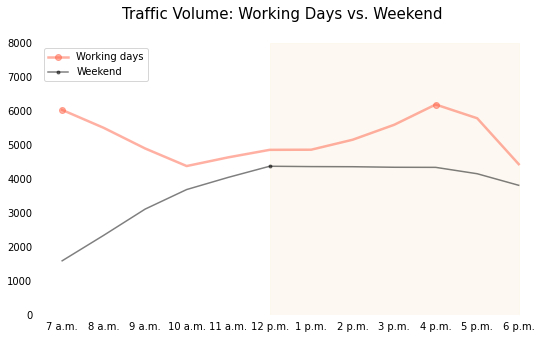

In [15]:
hour = ['7 a.m.', '8 a.m.', '9 a.m.', '10 a.m.', '11 a.m.', '12 p.m.',
        '1 p.m.', '2 p.m.', '3 p.m.', '4 p.m.', '5 p.m.', '6 p.m.']

fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(hour, by_hour_working['traffic_volume'], color='tomato', alpha=0.5, label='Working days', linewidth=2.5, marker='o', markevery=9)
ax.plot(hour, by_hour_weekend['traffic_volume'], color='black', alpha=0.5, label='Weekend', marker='.', markevery=[5])
plt.xticks(ticks=hour)
plt.legend()
plt.suptitle("Traffic Volume: Working Days vs. Weekend", fontsize=15)
plt.ylim(0, 8000)

ax.add_patch(Rectangle((5, 0),
                       6,
                       8000,
                       color='oldlace',
                       alpha=0.5))

plt.show()

On average, traffic is lighter during weekends compared to working days.

Taking in consideration only Saturday and Sunday, most traffic is concentrated in the afternoon, while mornings see an overall small amount of traggic on average.

As for working days, there are two significant peaks corresponding to 7 a.m. and 4 p.m. This is likely due to the high numbers of cars moving from or to work.

This highlights a contrast in traffic volume depending on whether it is a business day or the weekend. This can extend to a division between normal working days and holidays.

#### 3.1.4 Traffic Volume by Holiday

This part of the analysis presents a challenge. If we simply try to get a count of each holiday from the `daytime` dataset, we obtain a puzzling result:

In [16]:
daytime['holiday'].value_counts()

None    23877
Name: holiday, dtype: int64

Especially if we consider that the column `holiday` contains several distinct values, as we can see from the entire `traffic` dataset:

In [17]:
traffic['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

This is because the [original dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) only labels a holiday at the 00:00 timestamp, and not at the following timestamps for the same day - instead, it indicates it as `None`.

In [18]:
display(traffic.loc[[126,127,128,129,130], ['holiday', 'date_time']])

,holiday,date_time
126,Columbus Day,2012-10-08 00:00:00
127,None,2012-10-08 01:00:00
128,None,2012-10-08 02:00:00
129,None,2012-10-08 03:00:00
130,None,2012-10-08 04:00:00


This means that we must alter drastically the dataset to correctly label each holiday as such.

In [19]:
traffic['only_date'] = traffic['date_time'].dt.date # getting only the date (no timestamp)
traffic['dayofweek'] = traffic['date_time'].dt.dayofweek
grouped_holidays = traffic[traffic['holiday'] != 'None'].groupby('only_date').min() # group by date to set it as an index and filter by holiday
holidays = traffic[traffic['only_date'].isin(grouped_holidays.index)].copy() # if date is in index of the holidays -> holiday df
traffic['dayofweek'] = traffic['date_time'].dt.dayofweek
nonholidays = traffic[~traffic['only_date'].isin(grouped_holidays.index)].copy() # if date not in index of the holidays -> non holiday df
mapping = dict(grouped_holidays['holiday']) # dict where key is date (no timestamp) and value is holiday label
holidays['label_holiday'] = holidays['only_date'].map(mapping)
holidays[['holiday', 'date_time', 'label_holiday']].head()

,holiday,date_time,label_holiday
126,Columbus Day,2012-10-08 00:00:00,Columbus Day
127,None,2012-10-08 01:00:00,Columbus Day
128,None,2012-10-08 02:00:00,Columbus Day
129,None,2012-10-08 03:00:00,Columbus Day
130,None,2012-10-08 04:00:00,Columbus Day


As we did above, we split the `holidays` and `non_holidays` dataframes in daytime and nighttime and focus only on the data relevant to the day:

In [20]:
dayholidays = holidays[(holidays["date_time"].dt.hour >= 7).copy()
      & (holidays["date_time"].dt.hour < 19)].copy()
daynonholidays = nonholidays[(nonholidays["date_time"].dt.hour >= 7).copy()
      & (nonholidays["date_time"].dt.hour < 19)].copy()

In [21]:
print('Average traffic volume on non-holidays:', daynonholidays['traffic_volume'].mean())
print('Average traffic volume on holidays:', dayholidays['traffic_volume'].mean())

Average traffic volume on non-holidays: 4797.821505654839
Average traffic volume on holidays: 3596.447257383966


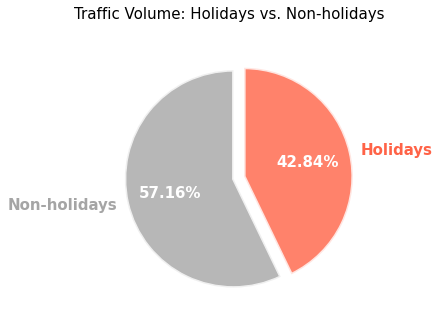

In [22]:
holidays_and_none = ['Non-holidays', 'Holidays']
cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, 2)))
colors[1] = 'tomato'
fig, ax = plt.subplots(figsize=(5,5))
patches, texts, pcts = ax.pie([daynonholidays['traffic_volume'].mean(), dayholidays['traffic_volume'].mean()],
                              labels=holidays_and_none,
                               colors=colors,
                               autopct= lambda x: '{:.2f}%'.format(x),
                               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white', "alpha": 0.8}, 
                              textprops={'fontsize': 15}, startangle=90, explode=(0, 0.1))
plt.setp(pcts, color='white', fontweight='bold', fontsize=15)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    texts[i].set_alpha(1)
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
plt.ylabel('')
plt.suptitle('Traffic Volume: Holidays vs. Non-holidays', fontsize=15)
plt.show()

On average, traffic volume is lighter during the holidays.

It might be worthwhile to see if any holiday has a greater impact on traffic.

In [23]:
by_holiday = dayholidays.groupby('label_holiday').mean()
print(by_holiday['traffic_volume'].sort_values(ascending=False))

label_holiday
State Fair                   5557.750000
Columbus Day                 5073.610169
Veterans Day                 4756.152542
Martin Luther King Jr Day    4094.000000
Washingtons Birthday         3988.630137
Labor Day                    3402.246377
Memorial Day                 2955.830769
Independence Day             2790.500000
New Years Day                2668.089552
Thanksgiving Day             2646.338028
Christmas Day                2286.840580
Name: traffic_volume, dtype: float64


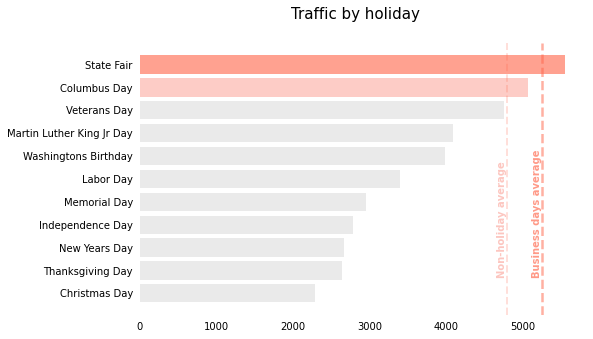

In [24]:
holiday_labels = by_holiday['traffic_volume'].sort_values().index.tolist()
holiday_width = by_holiday['traffic_volume'].sort_values()

daybusinessdays = daynonholidays[daynonholidays['dayofweek'] <= 4]

plt.figure(figsize=(8, 5))
bars = plt.barh(holiday_labels, holiday_width, color='gainsboro', alpha=0.6)
for bar in bars:
    if bar.get_width() > daybusinessdays['traffic_volume'].mean():
        bar.set_facecolor("tomato")
    elif bar.get_width() > daynonholidays['traffic_volume'].mean():
        bar.set_facecolor("salmon")
        bar.set_alpha(0.4)
plt.axvline(daynonholidays['traffic_volume'].mean(), linewidth=2, color='tomato', alpha=0.2, linestyle='dashed')
plt.axvline(daybusinessdays['traffic_volume'].mean(), linewidth=2.5, color='tomato', alpha=0.5, linestyle='dashed')
plt.text(daynonholidays['traffic_volume'].mean(), 0.75, 'Non-holiday average', ha='right', rotation='vertical', color='salmon', weight='bold',
         alpha=0.45)
plt.text(daybusinessdays['traffic_volume'].mean(), 0.75, 'Business days average', ha='right', rotation='vertical', color='tomato', weight='bold',
         alpha=0.65)
plt.ylabel('')
plt.suptitle('Traffic by holiday', fontsize=15)
plt.show()

Only two holidays reach an average traffic volume surpassing that of non-holidays, Columbus Day and the [Minnesota State Fair](https://www.mnstatefair.org/).

The State Fair is especially significant: its average traffic even surpasses that of business days. Located between Minneapolis and Saint Paut, it is one of the most popular fairs in the United States in terms of number of attendees.

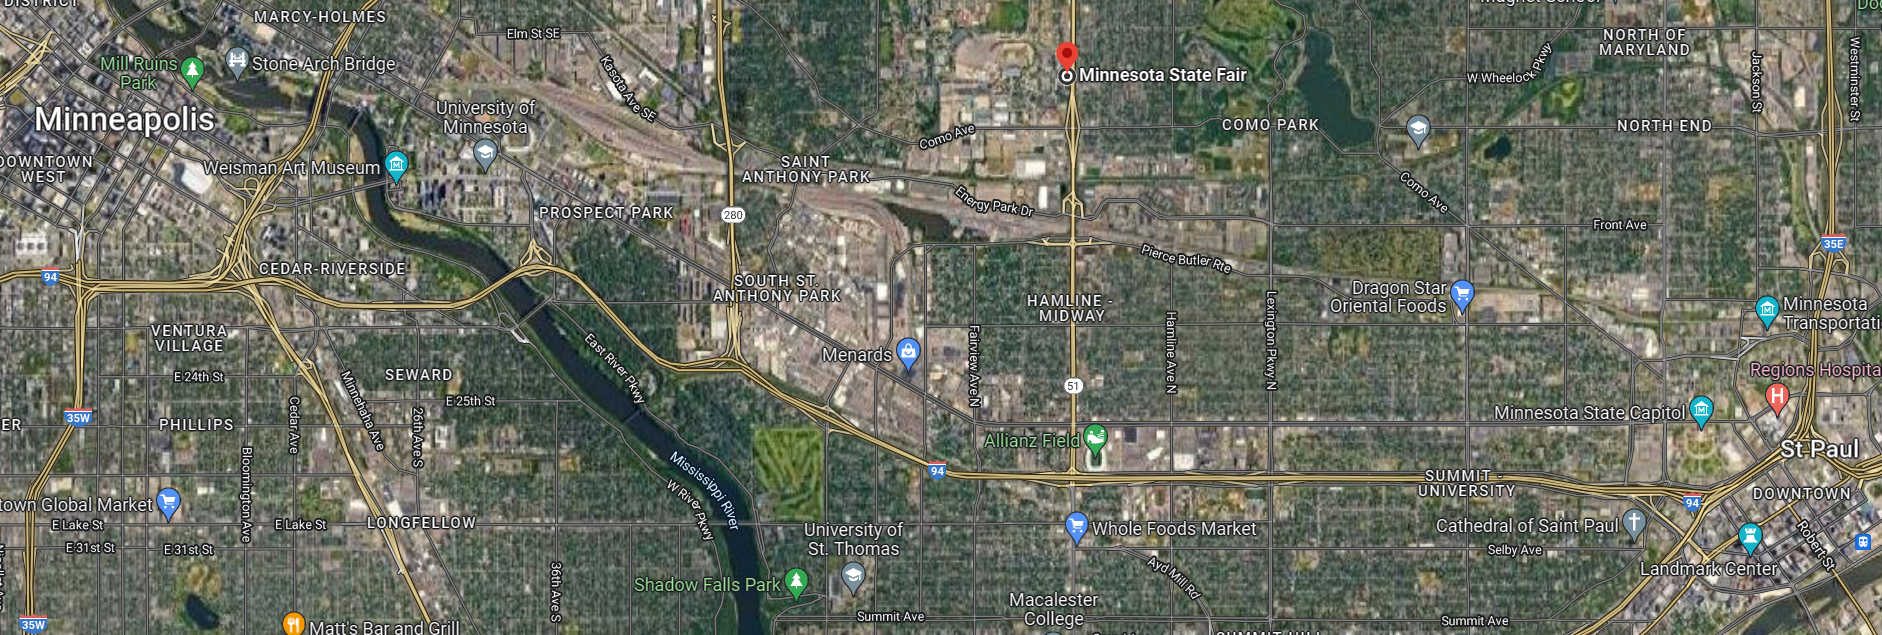

In [25]:
Image(filename='statefairminnesota.png')

The heavier traffic during this holiday is related to the location of the fair - to reach this destination by car, people from Minneapolis need to take I-94, contributing to the westbound traffic.

Furthermore, unlike the other holidays, the Minnesota State Fair runs for almost two weeks - a factor that may also contribute to such a high traffic volume.

#### 3.1.5 Conclusions

To sum up, the first conclusions that we can draw from this section are:

* On I-94, during the day, **traffic is generally heavier during warm months (from March to October)**, with the exception of July
* on average, **traffic is heavier on business days**, with the exception of the State Fair
* during business days, **traffic is heavier at 7 a.m. and 4 p.m.** (the rush hours)

Now, let's turn to exploring how **weather** affects traffic.

### 3.2 Weather

Another possible indicator of heavy traffic can be weather. The `daytime` dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main` and `weather_description`.

Let's start with the numerical weather columns.

#### 3.2.1 Numerical Weather Columns

In [26]:
daytime_weather = daytime.drop(["holiday", "date_time", "month",
                                "dayofweek", "hour"], axis=1)

daytime_weather.corr()[['traffic_volume']].head(4)

,traffic_volume
temp,0.128317
rain_1h,0.003697
snow_1h,0.001265
clouds_all,-0.032932


Observing the above data, it appears that weather indicators have a weak influence on traffic - as their correlation coefficients all tend to 0.

Nonetheless, the numerical weather column with the strongest correlation with `traffic_volume` is temperature (+0.13). Let's see this in a scatter plot.

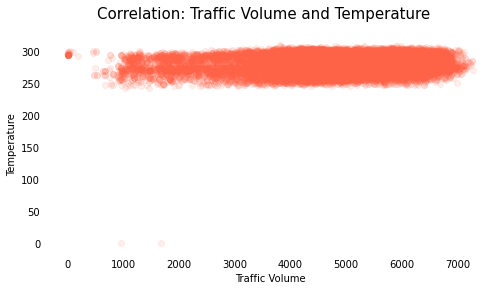

In [27]:
plt.figure(figsize=(8, 4))

plt.scatter(daytime["traffic_volume"], daytime["temp"], color='tomato', alpha=0.1)
plt.xlabel("Traffic Volume")
plt.ylabel("Temperature")
plt.suptitle("Correlation: Traffic Volume and Temperature", fontsize=15)
plt.show()

As expected, since the Pearson correlation coefficient (*r*) between traffic and temperature is quite close to 0, we can see that the volume of traffic is not significantly impacted by temperature.

Considering temperature has the strongest correlation among the numeric weather columns with traffic, it feels safe to assume that none of these columns can be a reliable indicator for heavy traffic.

To see if we can find more useful data, we will now look at the categorical weather-related columns: `weather_main` and `weather_description`.

#### 3.2.2 Categorical Weather Columns

In [28]:
by_weather_main = daytime.groupby('weather_main').mean()
by_weather_description = daytime.groupby('weather_description').mean()

In [29]:
weather_factors = by_weather_main['traffic_volume'].sort_values().index.tolist()

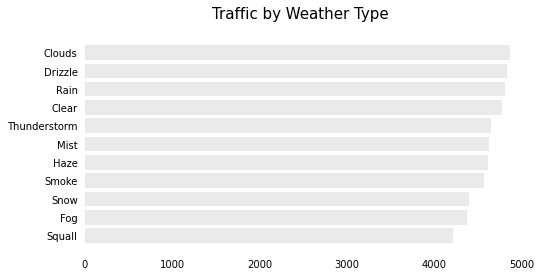

In [30]:
plt.figure(figsize=(8, 4))

plt.barh(weather_factors, by_weather_main["traffic_volume"].sort_values(), alpha=0.6, color='gainsboro')
plt.suptitle("Traffic by Weather Type", fontsize=15)
plt.show()

From the bar chart, it appars that weather types have no significant impact on heavy traffic - the average traffic volume fluctuates between around 4,000 and less than 5,000 in all types of weather.

Let's turn to weather descriptions to see if there is a difference.

In [31]:
weather_descr_values = by_weather_description["traffic_volume"].sort_values().index.tolist()

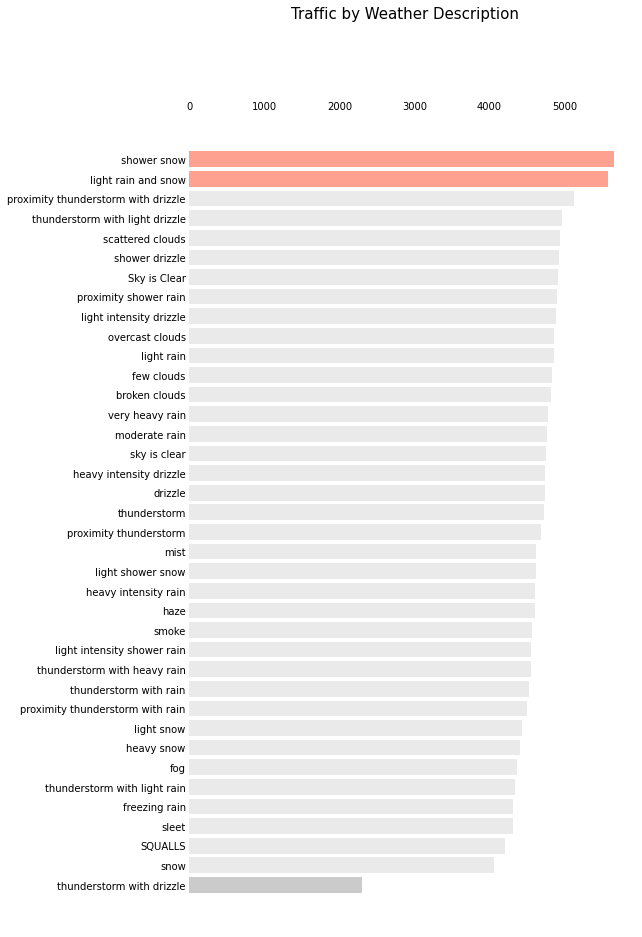

In [32]:
fig, ax = plt.subplots(figsize=(8, 15))

ax.xaxis.set_ticks_position('top')
ax.tick_params(axis=u'both', which=u'both',length=0)

y = weather_descr_values
width = by_weather_description["traffic_volume"].sort_values()

weather_color = ["tomato" if i > 5500 else "darkgrey" if i < (5500 / 2)
                 else "gainsboro" for i in width]

plt.barh(y, width, color = weather_color, alpha=0.6)
plt.suptitle("Traffic by Weather Description", fontsize=15)
plt.show()

As for weather descriptions, two heavy traffic indicators can be identified: 'shower snow' and 'light rain and snow'. These two types both have traffic exceeding 5,500 cars.

'Thunderstome with drizzle' is an indicator of light traffic: it the smallest value in the entire bar chart, with a volume of approximately 2,500 cars - half of the average traffic volume registered during the two most influential weather conditions.

#### 3.2.3 Conclusions

From observing how weather affects heavy traffic, we can make some generalizations:

* On I-94, **weather is generally not a strong indicator**
* **shower snow, and light rain and snow contribute to more traffic**
* **thurnderstorm with drizzle leads to less traffic**

### 3.3 Conclusion

For this project, we tried to find a few indicators of heavy traffic on I-94 Interstate Highway. We managed to find two types of indicators:

1. **Time Indicators**

* **traffic is usually heavier during warmer months** (March-October) with the exception of July
* **traffic is usually heavier on business days**, with the exception of some holidays (Minnesota State Fair)
* **rush hours are around 7 a.m. and 4 p.m.**

2. **Weather Indicators**

* **Shower snow**
* **Light rain and snow**

### 3.4 Future ideas

There is more to uncover from this dataset.

* July is the only warm month with a drastic drop in traffic volume. It would be advisable to look more into it.
* Although we have discovered early on that at night traffic is lower on average, exploring the nighttime dataset might prove to be useful to see if similar patterns are repeated